# Classification problem
### Considering binary gender classification
(0) Male

(1) Female

In [49]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [50]:
import utils as ut

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from neurocombat_sklearn import CombatModel



%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})
np.random.seed(42)

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'} 

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = pd.DataFrame()

In [52]:
df, phenotypic = ut.import_data(fisher=False)

#df = df.join(pd.DataFrame(phenotypic.Age), how='left')
#df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

df['Age'] = phenotypic['Age']

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

df = df.dropna(axis=0)
df = df.reset_index()
df['Site'] = df['Institution'].astype('category')
df['Site'] = df['Site'].cat.codes

# TEST = df[df.Subject.isin(df['Subject'].unique()[-20:])].reset_index()
# X_TEST = TEST.drop(columns=['Institution', 'Subject', 'Run','Gender', 'Age', 'Site','index'])
# y_TEST = TEST.Gender

# df = df[~df.Subject.isin(df['Subject'].unique()[-20:])].reset_index().drop(columns='index')

X = df.drop(columns=['Institution', 'Run', 'Age', 'Gender', 'Subject','Site'])
y = df.Gender.astype(int)


In [53]:
ROI_labels = pd.read_csv('/Users/rodrigo/Post-Grad/CC400/ROI_labels.csv')

In [54]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.39% 
 1 = 0.61%


In [57]:
df_dmn,labels = ut.DMN_extraction(X)
df_dmn = pd.DataFrame(df_dmn)
num_features = 52
df_dmn[['Institution', 'Run', 'Age', 'Gender', 'Subject','Site']] = df[['Institution', 'Run', 'Age', 'Gender', 'Subject','Site']]

In [58]:
np.random.seed(42)
random = df.Subject.isin(np.random.choice(df['Subject'].unique(),200))

df_train = df[~random]
df_test = df[random]

Age_train = df_train[['Age']]
Site_train = df_train[['Site']]
X_train = df_train.drop(columns=['Institution', 'Subject', 'Run','Gender', 'Age', 'Site'])
y_train = df_train.Gender

Age_test = df_test[['Age']]
Site_test = df_test[['Site']]
X_test = df_test.drop(columns=['Institution', 'Subject', 'Run', 'Gender', 'Age', 'Site'])
y_test = df_test.Gender

# X_train = pd.DataFrame(X_dmn[~random])  ###
# X_test = pd.DataFrame(X_dmn[random])    ###

In [59]:

# Creating model
model = CombatModel()

# Fitting the model and transforming the training set
X_train = model.fit_transform(X_train.values,
                                         Site_train) #X_train_har

# Harmonize test set using training set fitted parameters
X_test = model.transform(X_test.values,
                                    Site_test) #X_test_har

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [60]:
X_train, y_train, X_test, y_test = ut.cross_val_data(df_dmn, folds=5) #df

cv = []
for i in range(len(y_train)):
    trainIndices = y_train[i].index.values.astype(int)
    testIndices =  y_test[i].index.values.astype(int)
    cv.append( (trainIndices, testIndices) )

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/

In [61]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")

scores = cross_validate(dummy, X, y, cv=cv, scoring=scoring)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
#print('Dummy accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, dummy.predict(X_TEST))))

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Accuracy in test:0.62(0.02)
F1_scores 0.38(0.01)
Precision_scores 0.31(0.01)
Recall_scores 0.50(0.00)
ROC AUC 0.50(0.00)


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train[1], y_train[1])
y_pred = logreg.predict(X_test[1])

print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train[1], logreg.predict(X_train[1]))))
print('Logistic Regression accuracy score in val set: {0:0.4f}'. format(accuracy_score(y_test[1], y_pred)))

Logistic Regression accuracy score in training set: 0.9913
Logistic Regression accuracy score in val set: 0.6102


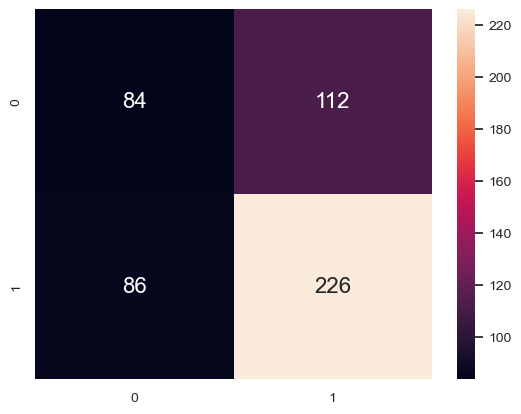

In [63]:
plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test[1], y_pred), annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()

### Cross Validation

In [64]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=200)

scores = cross_validate(logreg, X, y , cv=cv, scoring=scoring, n_jobs=-1)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

Accuracy in test:0.71(0.01)
F1_scores 0.68(0.02)
Precision_scores 0.69(0.01)
Recall_scores 0.68(0.02)
ROC AUC 0.76(0.02)


In [65]:
scores

{'fit_time': array([22.88127303, 24.57086492, 20.67605686, 25.4074719 , 25.711169  ]),
 'score_time': array([0.25972819, 0.63403201, 0.54840016, 0.18390822, 0.1423738 ]),
 'test_acc': array([0.70637584, 0.68897638, 0.72      , 0.71800948, 0.70552147]),
 'test_prec_macro': array([0.70037276, 0.67087523, 0.69416825, 0.70289425, 0.6918562 ]),
 'test_rec_macro': array([0.67568987, 0.65005233, 0.69216275, 0.69384572, 0.66603175]),
 'test_f1': array([0.67936007, 0.65376585, 0.69311167, 0.6970494 , 0.67070707]),
 'test_roc_auc': array([0.75233459, 0.71498888, 0.76390537, 0.77145963, 0.77384921])}

In [66]:
scores['Model'] = ['logreg']*5
results = pd.concat([results, pd.DataFrame.from_dict(scores)],axis=1)

In [67]:
# y_score = logreg.predict_proba(X_test)

# y_score = y_score[:,1]

# # Compute ROC curve and ROC area for each class
# fpr, tpr, _ = roc_curve(y_test, y_score)
# roc_auc = auc(fpr, tpr)

In [68]:
# plt.figure()
# lw = 2
# plt.plot(
#     fpr,
#     tpr,
#     color="darkorange",
#     lw=lw,
#     label="ROC curve (area = %0.2f)" % roc_auc,
# )
# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver operating characteristic example")
# plt.legend(loc="lower right")
# plt.show()

In [69]:
# # get importance
# importance = logreg.coef_[0]
# importance = np.sort(importance)

# plt.hist(importance)
# plt.show()

## SVM

In [70]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Setting possible values for the multiple hyperparameters of XGBoost
random_grid = {
    "C": [0, 0.25, 1, 5, 10],
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid']
}


svc = SVC(gamma='auto')
#svc.fit(X_train, y_train)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = GridSearchCV(estimator = svc, param_grid = random_grid,
                               cv = 3, verbose=1, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y.values.ravel())

#y_pred = svc.predict(X_test)

#print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, logreg.predict(X_train))))
#print('Logistic Regression accuracy score in test set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/si

GridSearchCV(cv=3, estimator=SVC(gamma='auto'), n_jobs=-1,
             param_grid={'C': [0, 0.25, 1, 5, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=1)

In [71]:
accuracy = rf_random.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 92.13%


In [72]:
print(rf_random.best_params_)
(pd.DataFrame.from_dict(rf_random.best_params_, orient='index')).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/SVC_params.csv')

{'C': 0.25, 'kernel': 'linear'}


In [73]:
# Best SVC model
svc = SVC(
    **rf_random.best_params_,
    gamma="auto"
)

scores = cross_validate(svc, X, y.values.ravel(), scoring=scoring,
                         cv=cv, n_jobs=-1,verbose=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


In [74]:
print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

Accuracy in test:0.71(0.02)
F1_scores 0.69(0.02)
Precision_scores 0.70(0.02)
Recall_scores 0.68(0.03)
ROC AUC 0.75(0.03)


In [75]:
results.columns

Index(['fit_time', 'score_time', 'test_acc', 'test_prec_macro',
       'test_rec_macro', 'test_f1', 'test_roc_auc', 'Model'],
      dtype='object')

In [76]:
results.columns

Index(['fit_time', 'score_time', 'test_acc', 'test_prec_macro',
       'test_rec_macro', 'test_f1', 'test_roc_auc', 'Model'],
      dtype='object')

In [77]:
scores['Model'] = ['SVC']*5
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

In [78]:
# svc.fit(X_train,y_train)
# print('Accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_test, svc.predict(X_test))))

## MLP

In [83]:
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(hidden_layer_sizes=(100,16,2),solver='adam',learning_rate='adaptive', shuffle=False, alpha=1, early_stopping=True)

#mlp.fit(X_train, y_train)
#y_pred = mlp.predict(X_test)


In [82]:
scores = cross_validate(mlp, X, y.values.ravel(), scoring=scoring,
                         cv=cv, n_jobs=-1,verbose=1)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

Accuracy in test:0.56(0.16)
F1_scores 0.47(0.20)
Precision_scores 0.42(0.24)
Recall_scores 0.58(0.10)
ROC AUC 0.61(0.13)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.2s finished


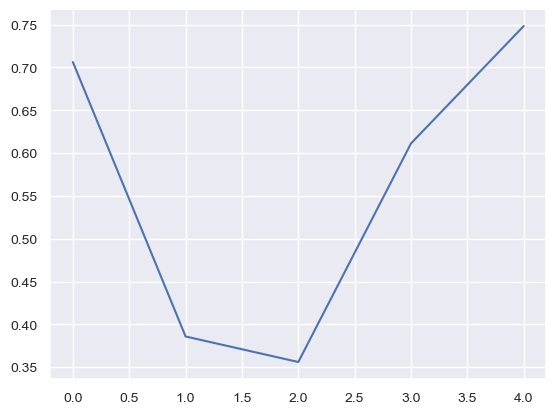

In [84]:
plt.plot(scores['test_acc'])

In [85]:
scores['Model'] = ['MLP']*5
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

### XGBoost

In [86]:
# Setting possible values for the multiple hyperparameters of XGBoost
random_grid = {
    "max_depth": [1, 2, 4, 8],
    "learning_rate": [0.001,0.05, 0.5],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0.001, 1, 10],
    "scale_pos_weight": [0,1, 3],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "n_estimators" : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]

}

# Using  Boosted trees
bst = XGBClassifier(booster='gbtree',tree_method='exact',objective='binary:logistic',n_jobs=-1)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = bst, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose=1, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y.values.ravel())


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [87]:
accuracy = rf_random.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

In [ ]:
a = {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 0.001, 'n_estimators': 600,
     'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}

In [ ]:
a

In [ ]:
print(rf_random.best_params_)
(pd.DataFrame.from_dict(rf_random.best_params_, orient='index')).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/xgboost_params.csv')

In [19]:
# Best xgboosting model
final_cl = XGBClassifier(
    **a,
    objective="binary:logistic",
    booster='gbtree',
    tree_method='exact',
    eval_metric='mlogloss',
    n_jobs=-1
)
# **rf_random.best_params_

scores = cross_validate(final_cl, X, y.values.ravel(), scoring=scoring,
                         cv=cv, n_jobs=-1,verbose=1)

#bst.fit(X_train, y_train.values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 61.6min remaining: 41.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 80.8min finished


In [20]:
print("Accuracy in val:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
#print('Accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, final_cl.predict(X_TEST))))

Accuracy in val:0.68(0.05)
F1_scores 0.61(0.05)
Precision_scores 0.69(0.07)
Recall_scores 0.62(0.04)
ROC AUC 0.74(0.07)


In [21]:
scores['Model'] = ['XGBoost']*10
results = results.merge(pd.DataFrame.from_dict(scores), how='outer')

In [22]:
results

,fit_time,score_time,test_acc,test_prec_macro,test_rec_macro,test_f1,test_roc_auc,Model
0,113.436413,0.464087,0.712838,0.681254,0.678644,0.679862,0.729230,logreg
1,112.223974,0.686256,0.686667,0.702438,0.675000,0.670730,0.785937,logreg
2,109.423476,1.329339,0.667883,0.616609,0.602186,0.605443,0.674570,logreg
3,115.508514,0.317689,0.741525,0.751246,0.724068,0.726681,0.762456,logreg
4,95.381335,1.118333,0.732558,0.716797,0.703316,0.707872,0.767028,logreg
5,115.306455,0.342255,0.737705,0.701113,0.692835,0.696399,0.790777,logreg
6,96.783327,0.703600,0.690265,0.656629,0.641610,0.645895,0.685360,logreg
7,114.693554,0.365203,0.788660,0.791652,0.775649,0.779759,0.841017,logreg
8,25.108315,0.209200,0.758824,0.716417,0.718709,0.717528,0.816982,logreg
9,24.267210,0.204222,0.681818,0.705409,0.674493,0.666505,0.807770,logreg


In [24]:
results.to_csv('/Users/rodrigo/Post-Grad/CC400/Results/models_DMN.csv')